# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 26
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

# Models

## Simple Poisson model

### Preparing data

In [8]:
spm_df = element_gameweek_df.copy()

In [9]:
spm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [10]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [11]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'goals_scored')

In [12]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [13]:
spm_response_df.head()

74    0
76    0
77    0
78    0
79    0
Name: goals_scored, dtype: int64

### Fitting model

In [14]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [15]:
print(spm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6674
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2363.9
Date:                Sat, 02 Mar 2019   Deviance:                       3410.3
Time:                        17:20:04   Pearson chi2:                 7.53e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2366      0.037    -59.723      0.000      -2.310      -2.163


### Model fit

In [16]:
spm_results.aic

4729.87418494977

In [17]:
spm_results.bic

-55361.806988078446

In [18]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(True, 4.0900616227190767e-13)

In [19]:
spm_results.resid_deviance.describe()

count    6675.000000
mean       -0.248634
std         0.670186
min        -0.462204
25%        -0.462204
50%        -0.462204
75%        -0.462204
max         3.771626
dtype: float64

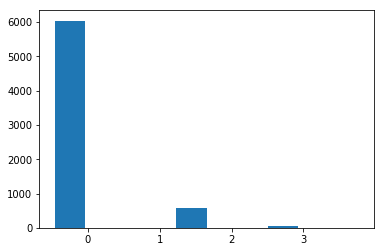

In [20]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Poisson minutes model

### Preparing data

In [21]:
spmm_df = element_gameweek_df.copy()

In [22]:
spmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [23]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [24]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [25]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'goals_scored')

In [26]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [27]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [28]:
print(spmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6673
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2321.7
Date:                Sat, 02 Mar 2019   Deviance:                       3325.8
Time:                        17:20:05   Pearson chi2:                 7.42e+03
No. Iterations:                     6                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.4698      0.306    -14.596      0.000      -5.070      -3.870
log_minutes     0.5349      0.071      7.542     

### Model fit

In [29]:
spmm_results.aic

4647.41549945014

In [30]:
spmm_results.bic

-55437.4595490948

In [31]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(True, 1.6869827756949007e-10)

In [32]:
spmm_results.resid_deviance.describe()

count    6675.000000
mean       -0.242323
std         0.663019
min        -0.504217
25%        -0.504217
50%        -0.504217
75%        -0.357952
max         3.778046
dtype: float64

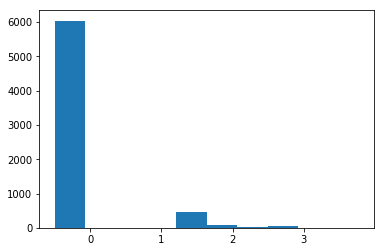

In [33]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Poisson teams model

### Preparing data

In [34]:
sptm_df = element_gameweek_df.copy()

In [35]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [36]:
sptm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [37]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [38]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'goals_scored')

In [39]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [40]:
sptm_response_df.head()

74    0
76    0
77    0
78    0
79    0
Name: goals_scored, dtype: int64

### Fitting model

In [41]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [42]:
print(sptm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6633
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2161.4
Date:                Sat, 02 Mar 2019   Deviance:                       3005.2
Time:                        17:20:06   Pearson chi2:                 7.42e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.0213      0.248    -12.170      0.000      -3.508      -2.535
was_home               0.175

### Model fit

In [43]:
sptm_results.aic

4406.853354863553

In [44]:
sptm_results.bic

-55405.77671435065

In [45]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(True, 2.277722455090725e-11)

In [46]:
sptm_results.resid_deviance.describe()

count    6675.000000
mean       -0.223586
std         0.632687
min        -1.240809
25%        -0.502521
50%        -0.371939
75%        -0.254570
max         3.653135
dtype: float64

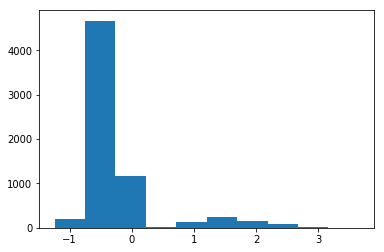

In [47]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Poisson teams minutes model

### Preparing data

In [48]:
sptmm_df = element_gameweek_df.copy()

In [49]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [50]:
sptmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes'
]

In [51]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [52]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [53]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'goals_scored')

In [54]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [55]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [56]:
print(sptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6632
Model Family:                 Poisson   Df Model:                           42
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2073.0
Date:                Sat, 02 Mar 2019   Deviance:                       2828.5
Time:                        17:20:07   Pearson chi2:                 8.04e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.6315      0.433    -15.312      0.000      -7.480      -5.783
was_home               0.168

### Model fit

In [57]:
sptmm_results.aic

4232.064430637609

In [58]:
sptmm_results.bic

-55573.759514093326

In [59]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(True, 0.0)

In [60]:
sptmm_results.resid_deviance.describe()

count    6675.000000
mean       -0.212693
std         0.615270
min        -1.385815
25%        -0.481830
50%        -0.334110
75%        -0.231489
max         3.479623
dtype: float64

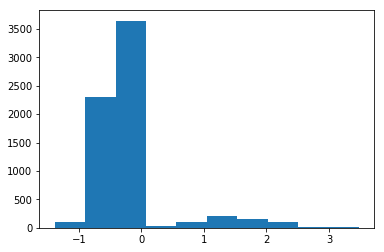

In [61]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Poisson player model

### Preparing data

In [149]:
sppm_df = element_gameweek_df.copy()

In [150]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [151]:
sppm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [152]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [153]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'goals_scored')

In [154]:
sppm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [156]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [157]:
print(sppm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6209
Model Family:                 Poisson   Df Model:                          465
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1812.0
Date:                Fri, 15 Mar 2019   Deviance:                       2306.5
Time:                        16:59:40   Pearson chi2:                 4.23e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.4208      0.730     -1.946      0.052      -2.852       0.010
opposition_team_2      0.205

### Model fit

In [158]:
sppm_results.aic

4556.068368039614

In [159]:
sppm_results.bic

-52370.764920268775

In [160]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(False, 1.0)

In [161]:
sppm_results.resid_deviance.describe()

count    6674.000000
mean       -0.150816
std         0.568236
min        -1.572823
25%        -0.472201
50%        -0.276712
75%        -0.000001
max         3.147251
dtype: float64

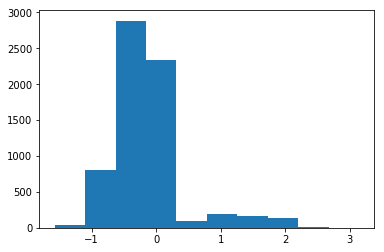

In [162]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Poisson player minutes model

### Preparing data

In [231]:
sppmm_df = element_gameweek_df.copy()

In [232]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [233]:
sppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [234]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [235]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [236]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'goals_scored')

In [237]:
sppmm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_581', 'element_585', 'element_586', 'element_587',
       'element_588', 'element_589', 'element_590', 'element_591',
       'element_592', 'log_minutes'],
      dtype='object', length=467)

### Fitting model

In [238]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [239]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6208
Model Family:                 Poisson   Df Model:                          466
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1776.8
Date:                Sat, 16 Mar 2019   Deviance:                       2235.9
Time:                        11:00:50   Pearson chi2:                 4.49e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.2436      0.828     -5.124      0.000      -5.867      -2.620
opposition_team_2      0.234

### Model fit

In [240]:
sppmm_results.aic

4487.51782495201

In [241]:
sppmm_results.bic

-52432.509338873104

In [242]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(False, 1.0)

In [243]:
sppmm_results.resid_deviance.describe()

count    6674.000000
mean       -0.147186
std         0.559823
min        -1.495930
25%        -0.455300
50%        -0.259715
75%        -0.000001
max         3.053995
dtype: float64

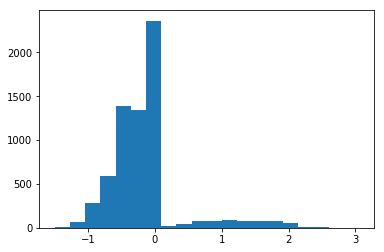

In [260]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Poisson player exposure model

### Preparing data

In [245]:
eppmm_df = element_gameweek_df.copy()

In [246]:
eppmm_df = player.add_categorical_variables(eppmm_df, 'opposition_team')
eppmm_df = player.add_categorical_variables(eppmm_df, 'element')

In [247]:
eppmm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [248]:
eppmm_exposure = eppmm_df['minutes']

In [249]:
eppmm_df = player.remove_redundant_columns(eppmm_df, eppmm_redundant_columns)

In [250]:
eppmm_response_df, eppmm_explanatory_df = player.get_response_explanatory_dfs(eppmm_df, 'goals_scored')

In [251]:
eppmm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [252]:
eppmm_results = sm.GLM(
    eppmm_response_df,
    eppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eppmm_exposure
).fit()

In [253]:
print(eppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6209
Model Family:                 Poisson   Df Model:                          465
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1784.0
Date:                Sat, 16 Mar 2019   Deviance:                       2250.3
Time:                        11:01:19   Pearson chi2:                 6.24e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.8402      0.730     -7.998      0.000      -7.271      -4.409
opposition_team_2      0.243

### Model fit

In [254]:
eppmm_results.aic

4499.947675626076

In [255]:
eppmm_results.bic

-52426.88561268231

In [256]:
eppmm_pearson_results = goodness_fit.pearson_chi_squared_test(eppmm_results)
eppmm_pearson_results

(False, 0.3802389271705421)

In [257]:
eppmm_results.resid_deviance.describe()

count    6674.000000
mean       -0.142087
std         0.563062
min        -1.542519
25%        -0.446494
50%        -0.232078
75%        -0.000001
max         3.537252
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


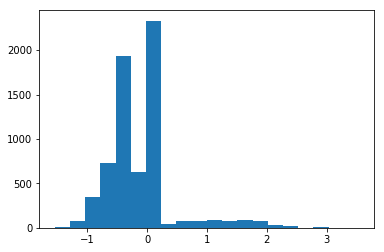

In [266]:
plt.figure()
plt.hist(eppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Gaussian model

### Preparing data

In [105]:
sgm_df = element_gameweek_df.copy()

In [106]:
sgm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [107]:
sgm_df = player.remove_redundant_columns(sgm_df, sgm_redundant_columns)

In [108]:
sgm_response_df, sgm_explanatory_df = player.get_response_explanatory_dfs(sgm_df, 'goals_scored')

### Fitting model

In [109]:
sgm_results = sm.GLM(
    sgm_response_df,
    sgm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [110]:
print(sgm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6673
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.12050484015820637
Method:                          IRLS   Log-Likelihood:                 -2408.0
Date:                Sat, 02 Mar 2019   Deviance:                        804.13
Time:                        17:20:52   Pearson chi2:                      804.
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0965      0.006     16.057      0.000       0.085       0.108
was_home       0.0206      0.008      2.429

### Model fit

In [111]:
sgm_results.aic

4820.092843466686

In [112]:
sgm_results.bic

-57959.13987847465

In [113]:
sgm_pearson_results = goodness_fit.pearson_chi_squared_test(sgm_results)
sgm_pearson_results

(False, 1.0)

In [114]:
sgm_results.resid_deviance.describe()

count    6.675000e+03
mean     4.257934e-17
std      3.471121e-01
min     -1.171360e-01
25%     -1.171360e-01
50%     -9.649386e-02
75%     -9.649386e-02
max      2.903506e+00
dtype: float64

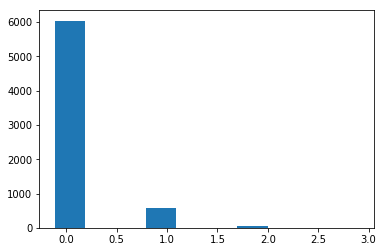

In [115]:
plt.figure()
plt.hist(sgm_results.resid_deviance)
plt.show()

## Simple Gaussian teams model

### Preparing data

In [116]:
sgtm_df = element_gameweek_df.copy()

In [117]:
sgtm_df = player.add_categorical_variables(sgtm_df, 'element_type')
sgtm_df = player.add_categorical_variables(sgtm_df, 'opposition_team')
sgtm_df = player.add_categorical_variables(sgtm_df, 'own_team')

In [118]:
sgtm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [119]:
sgtm_df = player.remove_redundant_columns(sgtm_df, sgtm_redundant_columns)

In [120]:
sgtm_response_df, sgtm_explanatory_df = player.get_response_explanatory_dfs(sgtm_df, 'goals_scored')

In [121]:
sgtm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [122]:
sgtm_response_df.head()

74    0
76    0
77    0
78    0
79    0
Name: goals_scored, dtype: int64

### Fitting model

In [123]:
sgtm_results = sm.GLM(
    sgtm_response_df,
    sgtm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [124]:
print(sgtm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6633
Model Family:                Gaussian   Df Model:                            41
Link Function:               identity   Scale:              0.11474764593641974
Method:                          IRLS   Log-Likelihood:                 -2224.6
Date:                Sat, 02 Mar 2019   Deviance:                        761.12
Time:                        17:20:53   Pearson chi2:                      761.
No. Iterations:                     2                                          
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0652      0.028      2.365      0.018       0.011       0.119
was_home           

### Model fit

In [125]:
sgtm_results.aic

4533.188593892439

In [126]:
sgtm_results.bic

-57649.90256202335

In [127]:
sgtm_pearson_results = goodness_fit.pearson_chi_squared_test(sgtm_results)
sgtm_pearson_results

(False, 1.0)

In [128]:
sgtm_results.resid_deviance.describe()

count    6.675000e+03
mean     1.072201e-15
std      3.377021e-01
min     -3.970383e-01
25%     -1.446570e-01
50%     -8.413399e-02
75%     -2.335948e-02
max      2.876859e+00
dtype: float64

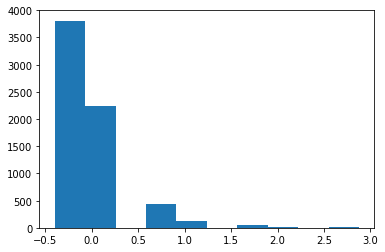

In [129]:
plt.figure()
plt.hist(sgtm_results.resid_deviance)
plt.show()

## Simple Gaussian player model

### Preparing data

In [214]:
sgpm_df = element_gameweek_df.copy()

In [215]:
sgpm_df = player.add_categorical_variables(sgpm_df, 'opposition_team')
sgpm_df = player.add_categorical_variables(sgpm_df, 'element')

In [216]:
sgpm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [217]:
sgpm_df = player.remove_redundant_columns(sgpm_df, sgpm_redundant_columns)

In [218]:
sgpm_response_df, sgpm_explanatory_df = player.get_response_explanatory_dfs(sgpm_df, 'goals_scored')

In [219]:
sgpm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [221]:
sgpm_results = sm.GLM(
    sgpm_response_df,
    sgpm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [222]:
print(sgpm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6209
Model Family:                Gaussian   Df Model:                           465
Link Function:               identity   Scale:              0.10832371859463473
Method:                          IRLS   Log-Likelihood:                 -1811.9
Date:                Fri, 15 Mar 2019   Deviance:                        672.58
Time:                        17:03:43   Pearson chi2:                      673.
No. Iterations:                     2                                          
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2462      0.118      2.087      0.037       0.015       0.477
opposition_team_2  

### Model fit

In [223]:
sgpm_results.aic

4555.701130198417

In [224]:
sgpm_results.bic

-54004.64494785972

In [225]:
sgpm_pearson_results = goodness_fit.pearson_chi_squared_test(sgpm_results)
sgpm_pearson_results

(False, 1.0)

In [226]:
sgpm_results.resid_deviance.describe()

count    6.675000e+03
mean     2.652892e-17
std      3.174531e-01
min     -8.086204e-01
25%     -1.189562e-01
50%     -4.058364e-02
75%      5.806103e-03
max      2.765964e+00
dtype: float64

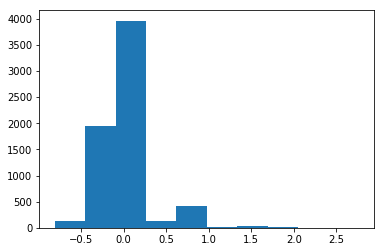

In [227]:
plt.figure()
plt.hist(sgpm_results.resid_deviance)
plt.show()

# Model comparison

In [228]:
{
    'simple Poisson': spm_results.aic,
    'simple Poisson teams': sptm_results.aic,
    'simple Poisson players': sppm_results.aic,
    'simple Poisson minutes': spmm_results.aic,
    'simple Poisson teams minutes': sptmm_results.aic,
    'simple Poisson players minutes': sppmm_results.aic,
    'simple Poisson players exposure': eppmm_results.aic,
    'simple Gaussian': sgm_results.aic,
    'simple Gaussian teams': sgtm_results.aic,
    'simple Gaussian players': sgpm_results.aic
}

{'simple Poisson': 4729.87418494977,
 'simple Poisson teams': 4406.853354863553,
 'simple Poisson players': 4556.068368039614,
 'simple Poisson minutes': 4647.41549945014,
 'simple Poisson teams minutes': 4232.064430637609,
 'simple Poisson players minutes': 4487.51782495201,
 'simple Poisson players exposure': 4499.947675626076,
 'simple Gaussian': 4820.092843466686,
 'simple Gaussian teams': 4533.188593892439,
 'simple Gaussian players': 4555.701130198417}

AIC prefers simple Poisson teams minutes

In [229]:
{
    'simple Poisson': spm_results.bic,
    'simple Poisson teams': sptm_results.bic,
    'simple Poisson players': sppm_results.bic,
    'simple Poisson minutes': spmm_results.bic,
    'simple Poisson teams minutes': sptmm_results.bic,
    'simple Poisson players minutes': sppmm_results.bic,
    'simple Poisson players exposure': eppmm_results.bic,    
    'simple Gaussian': sgm_results.bic,
    'simple Gaussian teams': sgtm_results.bic,
    'simple Gaussian players': sgpm_results.bic
}

{'simple Poisson': -55361.806988078446,
 'simple Poisson teams': -55405.77671435065,
 'simple Poisson players': -52370.764920268775,
 'simple Poisson minutes': -55437.4595490948,
 'simple Poisson teams minutes': -55573.759514093326,
 'simple Poisson players minutes': -52432.509338873104,
 'simple Poisson players exposure': -52426.88561268231,
 'simple Gaussian': -57959.13987847465,
 'simple Gaussian teams': -57649.90256202335,
 'simple Gaussian players': -54004.64494785972}

BIC prefers simple Gaussian model, followed by simple Gaussian teams

In [230]:
{
    'simple Poisson': spm_pearson_results,
    'simple Poisson teams': sptm_pearson_results,
    'simple Poisson players': sppm_pearson_results,
    'simple Poisson minutes': spmm_pearson_results,
    'simple Poisson teams minutes': sptmm_pearson_results,
    'simple Poisson players minutes': sppmm_pearson_results,
    'simple Poisson players exposure': eppmm_pearson_results,
    'simple Gaussian': sgm_pearson_results,
    'simple Gaussian teams': sgtm_pearson_results,
    'simple Gaussian players': sgpm_pearson_results
}

{'simple Poisson': (True, 4.0900616227190767e-13),
 'simple Poisson teams': (True, 2.277722455090725e-11),
 'simple Poisson players': (False, 1.0),
 'simple Poisson minutes': (True, 1.6869827756949007e-10),
 'simple Poisson teams minutes': (True, 0.0),
 'simple Poisson players minutes': (False, 1.0),
 'simple Poisson players exposure': (False, 0.3802389271705421),
 'simple Gaussian': (False, 1.0),
 'simple Gaussian teams': (False, 1.0),
 'simple Gaussian players': (False, 1.0)}

simple Poisson players, simple Poisson players minutes and simple Poisson players exposure fit. Gaussian models fit